In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

In [2]:
train_df = pd.read_csv("/Users/radhikapanchal/Downloads/cosmicclassifierTraining.csv")
test_df = pd.read_csv('/Users/radhikapanchal/Downloads/cosmicclassifierTest.csv')

In [3]:
print(train_df.shape)
print('\n')
print(test_df.shape)

(60000, 11)


(10000, 10)


In [4]:
print("\nDescriptive statistics for numerical columns:")
print(train_df.describe())


Descriptive statistics for numerical columns:
       Atmospheric Density  Surface Temperature       Gravity  Water Content  \
count         57016.000000         56968.000000  57016.000000   56923.000000   
mean             -0.000202            -0.000288     -0.000469       0.001938   
std               2.263527             1.936598      1.804605       1.689267   
min              -4.364843            -5.503527     -5.553877      -5.816755   
25%              -1.555810            -1.426786     -1.279002      -1.218870   
50%              -0.188670            -0.330037      0.046231      -0.004676   
75%               1.308113             1.503646      1.255432       1.063391   
max               9.324018             5.638094      6.030290       6.287045   

       Mineral Abundance  Orbital Period  Proximity to Star  \
count       57079.000000    57003.000000       57055.000000   
mean           -0.000730       -0.001043           0.000188   
std             1.605524        1.511685   

In [5]:
train_df.head(5)

,Atmospheric Density,Surface Temperature,Gravity,Water Content,Mineral Abundance,Orbital Period,Proximity to Star,Magnetic Field Strength,Radiation Levels,Atmospheric Composition Index,Prediction
0,0.472806,NaN,-0.313872,-2.089299,-0.152201,-0.885649,0.900105,NaN,Category_6,0.692907,5.0
1,4.180154,-1.157515,2.430956,-1.595850,-3.188678,-0.609434,-0.199828,Category_9,Category_9,NaN,0.0
2,-0.129008,1.621592,-0.785741,2.081196,-1.413796,-0.095152,-3.502577,NaN,Category_8,-0.677182,4.0
3,-3.122000,-2.299818,1.072092,0.353524,-0.192529,2.917067,-1.972329,NaN,Category_11,0.109429,1.0
4,-1.459426,2.890268,0.148757,-0.804439,0.494875,0.044910,-0.438796,Category_6,Category_10,0.407941,9.0


In [6]:
test_df.head(5)

,Atmospheric Density,Surface Temperature,Gravity,Water Content,Mineral Abundance,Orbital Period,Proximity to Star,Magnetic Field Strength,Radiation Levels,Atmospheric Composition Index
0,-1.303074,2.932540,-0.168043,-1.220249,-1.942662,0.950473,1.540782,Category_13,Category_6,-0.729809
1,0.081124,-3.747390,-0.598897,1.563487,-0.199953,-1.844926,1.095349,Category_11,Category_10,-0.341850
2,-3.709952,-1.689588,0.259499,1.020046,-2.094565,0.344641,-0.094227,Category_9,Category_9,-0.532658
3,4.838804,0.442909,0.995312,-0.385272,-0.818065,-1.903998,2.727794,Category_10,Category_9,-0.205558
4,0.742217,2.802281,-1.144759,2.475840,-0.585959,0.880694,-1.942863,Category_11,Category_6,0.763087


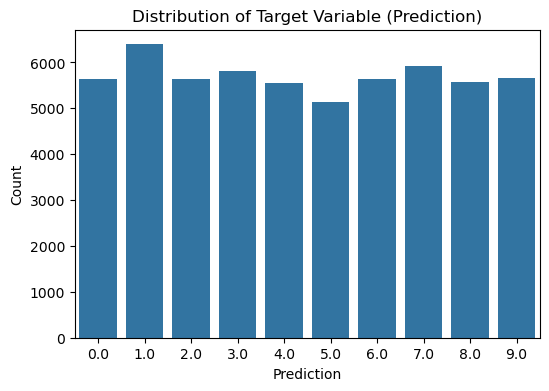

In [7]:
#Distribution of the Target Variable

num_cols = [
    "Atmospheric Density", "Surface Temperature", "Gravity", "Water Content",
    "Mineral Abundance", "Orbital Period", "Proximity to Star",
    "Atmospheric Composition Index"
]

plt.figure(figsize=(6, 4))
sns.countplot(x='Prediction', data=train_df)
plt.title("Distribution of Target Variable (Prediction)")
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.show()

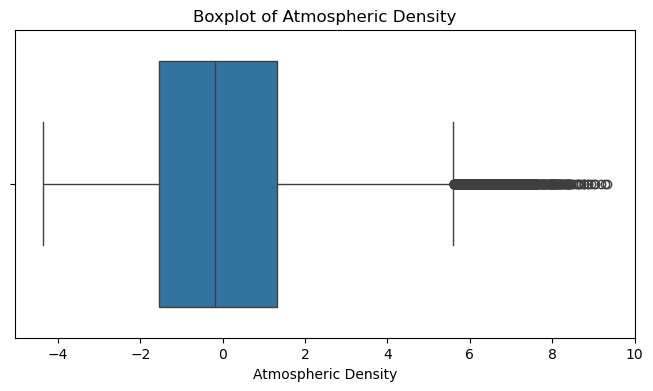

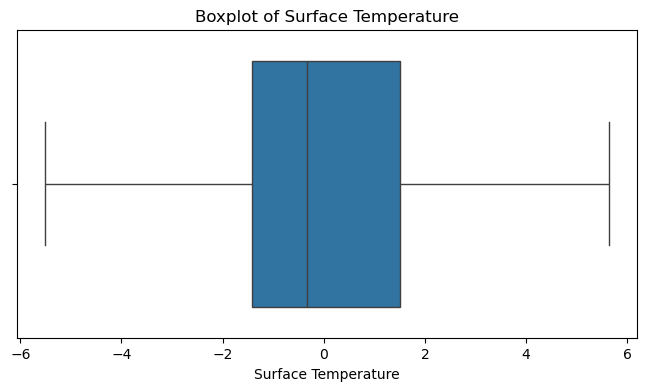

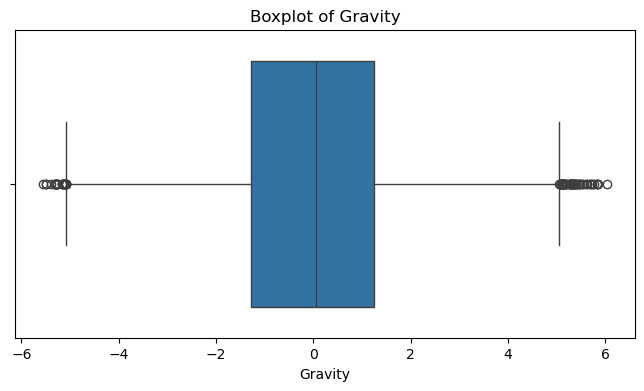

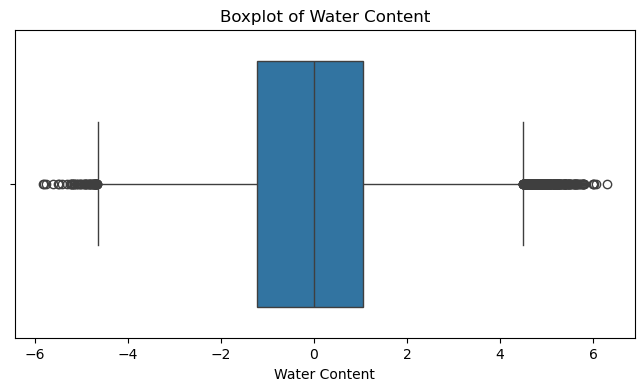

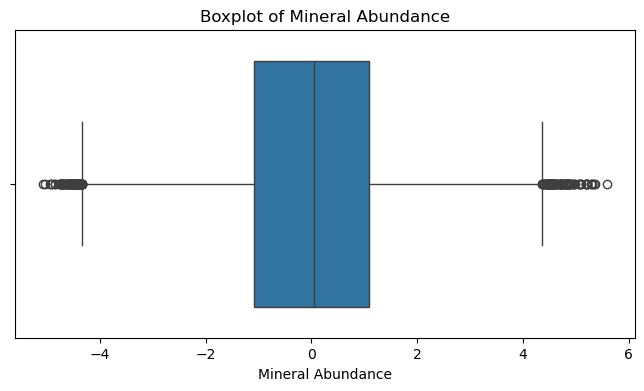

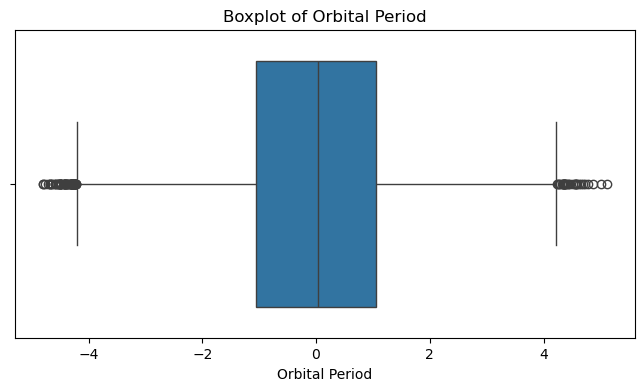

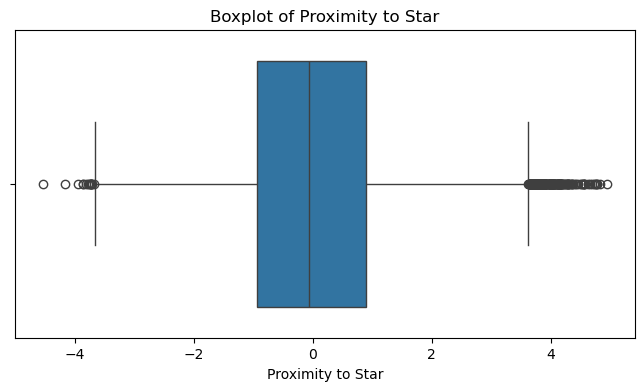

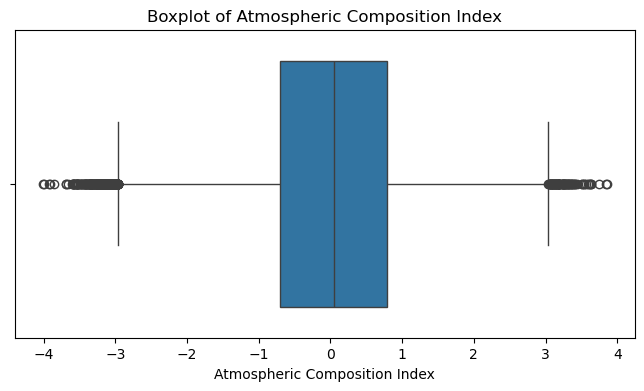

In [8]:
#Boxplots for Outlier Detection in Numerical Features
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=train_df[col])
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.show()

In [9]:
train_df.isnull().sum()

Atmospheric Density              2984
Surface Temperature              3032
Gravity                          2984
Water Content                    3077
Mineral Abundance                2921
Orbital Period                   2997
Proximity to Star                2945
Magnetic Field Strength          3058
Radiation Levels                 3021
Atmospheric Composition Index    2942
Prediction                       3039
dtype: int64

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report


num_cols = [
    "Atmospheric Density", "Surface Temperature", "Gravity", "Water Content",
    "Mineral Abundance", "Orbital Period", "Proximity to Star",
    "Atmospheric Composition Index"
]

for col in num_cols:
    train_df[col + "_missing"] = train_df[col].isnull().astype(int)


cat_cols = ['Magnetic Field Strength', 'Radiation Levels']

impute_values = {}
for col in num_cols:
    if abs(train_df[col].skew()) < 0.5:
        impute_values[col] = train_df[col].mean()
    else:
        impute_values[col] = train_df[col].median()

cat_impute = {}
for col in cat_cols:
    cat_impute[col] = train_df[col].mode()[0]
    
for col in cat_cols:
    train_df[col] = train_df[col].fillna(cat_impute[col])
for col in num_cols:
    train_df[col] = train_df[col].fillna(impute_values[col])

train_df = train_df.dropna(subset=['Prediction'])

#Feature Engineering (Interaction Features)
train_df['Gravity_Proximity_Ratio'] = train_df['Gravity'] / (train_df['Proximity to Star'] + 1)
train_df['Water_Density_Product'] = train_df['Water Content'] * train_df['Atmospheric Density']
train_df['Temp_Gravity_Ratio'] = train_df['Surface Temperature'] / (train_df['Gravity'] + 1)

#Define Final Feature Lists
continuous_cols = [
    'Atmospheric Density', 'Surface Temperature', 'Gravity', 
    'Water Content', 'Mineral Abundance', 'Orbital Period', 
    'Proximity to Star', 'Atmospheric Composition Index',
    'Gravity_Proximity_Ratio', 'Water_Density_Product', 'Temp_Gravity_Ratio'
]
missing_indicator_cols = [col + "_missing" for col in num_cols]
final_cont_cols = continuous_cols + missing_indicator_cols
categorical_cols = cat_cols
target = 'Prediction'

#Define Features (X) and Target (y)
X = train_df[final_cont_cols + categorical_cols].copy()
y = train_df[target]

# Convert categorical columns to string type
for col in categorical_cols:
    X.loc[:, col] = X[col].astype(str)

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#K-Fold Cross-Validation with Given Parameters
optimal_params = {'learning_rate': 0.05, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 8}
FOLDS = 7
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)
oof_predictions = np.zeros(len(X_train))
fold_scores = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold + 1}...")
    X_train_fold = X_train.iloc[train_index].copy()
    X_val_fold = X_train.iloc[val_index].copy()
    y_train_fold = y_train.iloc[train_index]
    y_val_fold = y_train.iloc[val_index]
    
    cat_model_fold = CatBoostClassifier(random_state=42, verbose=0, **optimal_params)
    cat_model_fold.fit(X_train_fold, y_train_fold, cat_features=categorical_cols)
    
    y_pred = cat_model_fold.predict(X_val_fold).flatten()
    oof_predictions[val_index] = y_pred
    
    fold_accuracy = accuracy_score(y_val_fold, y_pred)
    fold_scores.append(fold_accuracy)
    print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")

final_accuracy = np.mean(fold_scores)
print(f"\nOverall K-Fold Accuracy: {final_accuracy:.4f}")
print("\nClassification Report (K-Fold on Training Set):")
print(classification_report(y_train, oof_predictions))

#Final Model Training and Test Set Evaluation
final_cat_model = CatBoostClassifier(random_state=42, verbose=0, **optimal_params)
final_cat_model.fit(X_train, y_train, cat_features=categorical_cols)
y_test_pred = final_cat_model.predict(X_test).flatten()

print("\nTest Set Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))



Training Fold 1...
Fold 1 Accuracy: 0.8966

Training Fold 2...
Fold 2 Accuracy: 0.8957

Training Fold 3...
Fold 3 Accuracy: 0.8914

Training Fold 4...
Fold 4 Accuracy: 0.8943

Training Fold 5...
Fold 5 Accuracy: 0.8871

Training Fold 6...
Fold 6 Accuracy: 0.8935

Training Fold 7...
Fold 7 Accuracy: 0.8986

Overall K-Fold Accuracy: 0.8939

Classification Report (K-Fold on Training Set):
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      4525
         1.0       0.96      0.98      0.97      5078
         2.0       0.91      0.92      0.91      4520
         3.0       0.87      0.85      0.86      4642
         4.0       0.87      0.86      0.86      4444
         5.0       0.86      0.87      0.87      4095
         6.0       0.93      0.94      0.93      4533
         7.0       0.93      0.91      0.92      4740
         8.0       0.84      0.85      0.85      4467
         9.0       0.81      0.82      0.82      4524

    accuracy  

In [11]:
test_df = pd.read_csv("/Users/radhikapanchal/Downloads/cosmicclassifierTest.csv")

# Process numerical columns: add missing indicators and fill missing values using training imputation values
for col in num_cols:
    test_df[col + "_missing"] = test_df[col].isnull().astype(int)
    test_df[col] = test_df[col].fillna(impute_values[col])

# Process categorical columns: fill missing values using training mode values
for col in cat_cols:
    test_df[col] = test_df[col].fillna(cat_impute[col])

#Feature Engineering on Test Data
test_df['Gravity_Proximity_Ratio'] = test_df['Gravity'] / (test_df['Proximity to Star'] + 1)
test_df['Water_Density_Product'] = test_df['Water Content'] * test_df['Atmospheric Density']
test_df['Temp_Gravity_Ratio'] = test_df['Surface Temperature'] / (test_df['Gravity'] + 1)

# Prepare test features: same columns as used for training
X_test = test_df[final_cont_cols + cat_cols].copy()
for col in cat_cols:
    X_test[col] = X_test[col].astype(str)

#Predict on Test Set
test_predictions = final_cat_model.predict(X_test).flatten()

# Add predictions to the test dataframe (or save them separately)
test_df['Prediction'] = test_predictions

# Save predictions to a CSV file (optional)
test_df.to_csv("cosmicclassifierTest_predictions.csv", index=False)

# Print a sample of predictions
print("Sample Test Predictions:")
print(test_df[['Prediction']].head())

Sample Test Predictions:
   Prediction
0         7.0
1         2.0
2         1.0
3         0.0
4         4.0
